## **(-)Mounting Resource**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install xlsxwriter

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 11.8 MB/s eta 0:00:00


## **(o) Requirements, and Prepare**

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import shutil
import random
import re

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

**Gathering Data**

In [ ]:
# Path ke folder dataset
dataset_path = '/content/drive/MyDrive/Dataset/garbage-dataset'

# Mendapatkan daftar folder dalam dataset
classes = os.listdir(dataset_path)

In [ ]:
class_counts = {}
sample_images = {}
sample_edges = {}

In [ ]:
count_various_classes = len(classes)

## **(i) EDA**

Distribusi Class & Data

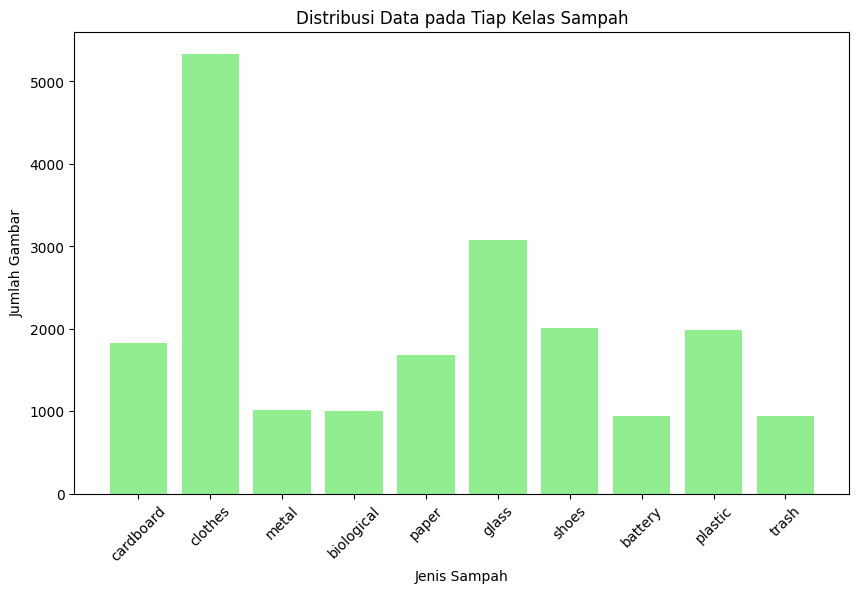

In [ ]:
for garbage_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, garbage_class)

    if os.path.isdir(class_path):  # Pastikan path tersebut dalam folder
        images = os.listdir(class_path)
        class_counts[garbage_class] = len(images)  # Hitung jumlah gambar per kelas

        # Ambil satu contoh gambar dari setiap kelas
        if images:
            sample_images[garbage_class] = os.path.join(class_path, images[0])

# Menampilkan distribusi data
plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='lightgreen')
plt.title("Distribusi Data pada Tiap Kelas Sampah")
plt.xlabel("Jenis Sampah")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=45)
plt.show()

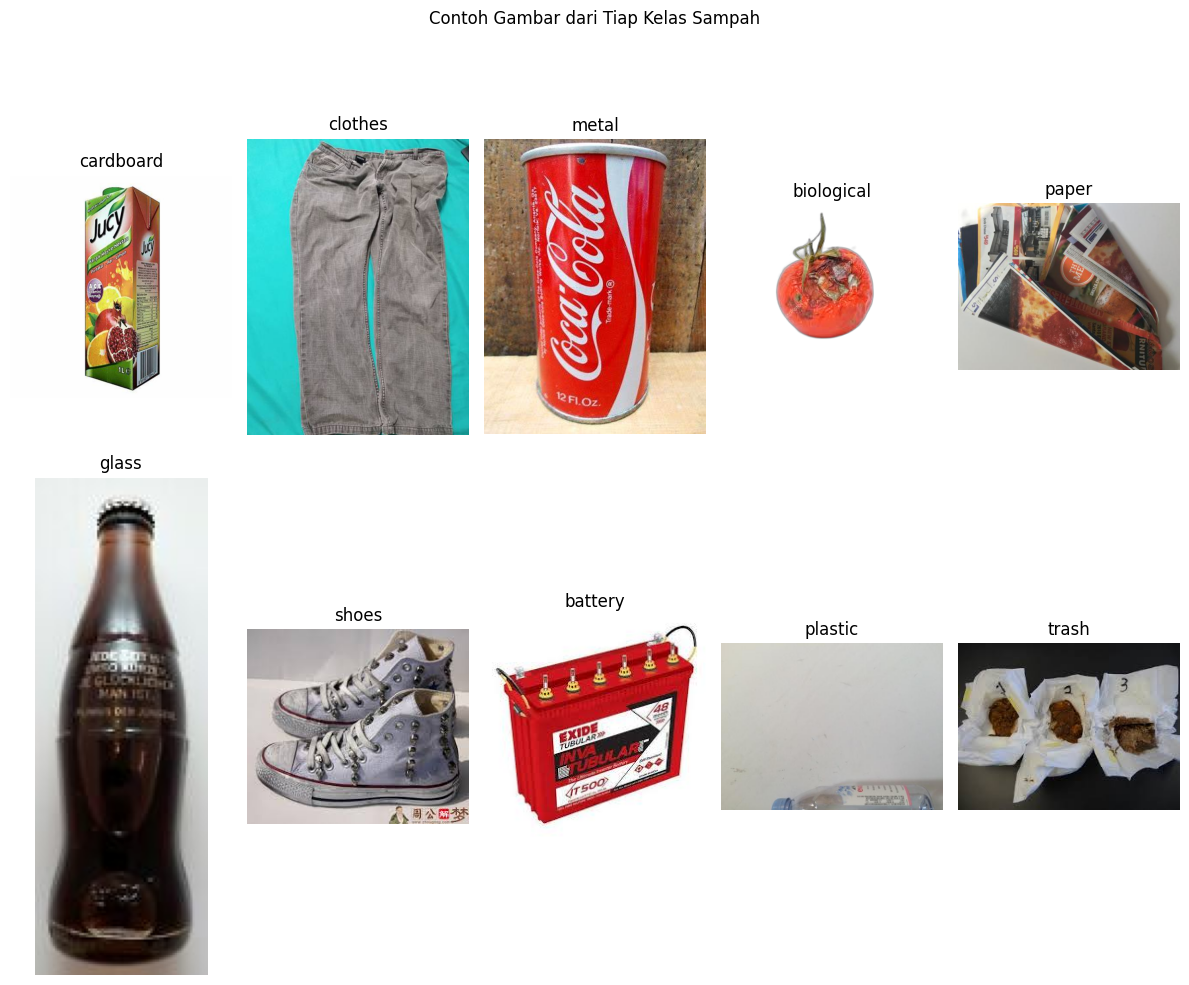

In [ ]:
plt.figure(figsize=(12, 10))
for i, (garbage_class, image_path) in enumerate(sample_images.items(), 1):
    img = Image.open(image_path)
    plt.subplot(2, 5, i)  # Menyesuaikan jumlah subplot dengan kelas yang ada (2 baris, 3 kolom)
    plt.imshow(img)
    plt.title(garbage_class)
    plt.axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas Sampah")
plt.tight_layout()
plt.show()

####**(ii) Edge Detection**

Sobel EDA : Edge Detection

In [ ]:
def extract_edges_sobel(image_path):
    """
    Fungsi untuk mengekstrak tepi dari gambar menggunakan operator Sobel.

    Parameters:
        image_path (str): Path ke file gambar.

    Returns:
        edge_image (numpy.ndarray): Gambar dengan tepi yang diekstrak.
    """
    # Membaca gambar dalam format grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Menggunakan Sobel untuk ekstraksi tepi di sumbu X dan Y
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

    # Menggabungkan kedua hasil Sobel
    sobel_combined = cv2.magnitude(sobelx, sobely)

    # Mengonversi hasil ke format 8-bit
    edge_image = cv2.convertScaleAbs(sobel_combined)

    return edge_image


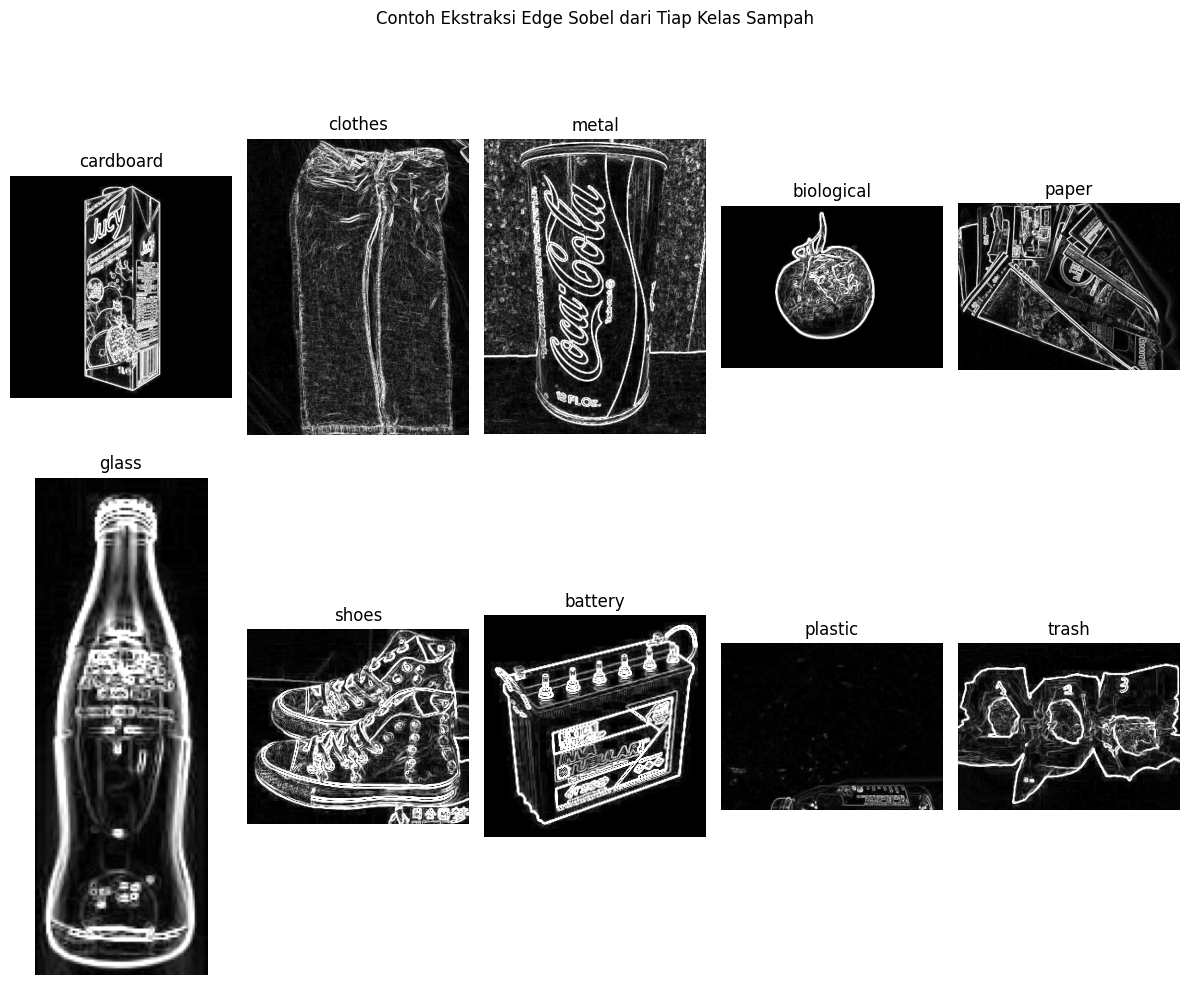

In [ ]:

for garbage_class in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, garbage_class)

    if os.path.isdir(class_path):  # Pastikan path adalah folder
        images = os.listdir(class_path)

        # Pilih satu gambar sebagai contoh
        if images:
            sample_image_path = os.path.join(class_path, images[0])
            edge_image = extract_edges_sobel(sample_image_path)
            sample_edges[garbage_class] = edge_image

# Menampilkan contoh hasil ekstraksi edge Sobel dari tiap kelas
plt.figure(figsize=(12, 10))
for i, (garbage_class, edge_image) in enumerate(sample_edges.items(), 1):
    plt.subplot(2, 5, i)  # Menyesuaikan jumlah subplot dengan kelas yang ada (2 baris, 3 kolom)
    plt.imshow(edge_image, cmap='gray')
    plt.title(garbage_class)
    plt.axis('off')

plt.suptitle("Contoh Ekstraksi Edge Sobel dari Tiap Kelas Sampah")
plt.tight_layout()
plt.show()

## **(iii) Splitting Dataset**

In [ ]:
import os
import random
import shutil

def split_dataset(dataset_path, output_path, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):
    """
    Memisahkan dataset menjadi train, validation, dan test berdasarkan rasio yang ditentukan,
    serta menambahkan prefix nama kelas pada setiap file gambar.

    Parameters:
        dataset_path (str): Path ke folder dataset asli.
        output_path (str): Path ke folder output untuk menyimpan dataset yang sudah dipisah.
        train_ratio (float): Proporsi data untuk train set.
        val_ratio (float): Proporsi data untuk validation set.
        test_ratio (float): Proporsi data untuk test set.
    """
    # Membuat folder output jika belum ada
    os.makedirs(output_path, exist_ok=True)
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(output_path, split), exist_ok=True)

    # Mendapatkan daftar kelas (subfolder di dalam dataset)
    classes = os.listdir(dataset_path)

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            # Mendapatkan daftar file gambar dan mengacak urutannya
            images = os.listdir(class_path)
            random.shuffle(images)

            # Menghitung jumlah gambar untuk setiap split
            total_images = len(images)
            train_count = int(total_images * train_ratio)
            val_count = int(total_images * val_ratio)

            # Menghitung indeks pemisahan gambar
            train_images = images[:train_count]
            val_images = images[train_count:train_count + val_count]
            test_images = images[train_count + val_count:]

            # Membuat folder kelas di dalam folder split dan menyalin file gambar
            for split, split_images in zip(['train', 'val', 'test'], [train_images, val_images, test_images]):
                split_class_path = os.path.join(output_path, split, class_name)
                os.makedirs(split_class_path, exist_ok=True)

                # Menyalin file gambar ke folder split yang sesuai dan mengganti nama file
                for i, image_name in enumerate(split_images, start=1):
                    src_image_path = os.path.join(class_path, image_name)
                    dst_image_name = f"{class_name}_{i}.jpg"
                    dst_image_path = os.path.join(split_class_path, dst_image_name)
                    shutil.copy(src_image_path, dst_image_path)


In [ ]:
# Path untuk menyimpan dataset yang sudah dipisah
output_path = 'Dataset_split/'

# Menjalankan fungsi untuk memisahkan dataset
split_dataset(dataset_path, output_path)

## **(iii & iv) Preprocessing**

Functions Preparing

In [ ]:
def resize_images(input_path, output_path, size=(224, 224)):
    """
    Meresize setiap gambar dalam input_path ke ukuran yang ditentukan
    dan menyimpannya di output_path.

    Parameters:
        input_path (str): Path ke folder input (misalnya Dataset_split).
        output_path (str): Path ke folder output untuk menyimpan gambar yang sudah diresize.
        size (tuple): Ukuran yang diinginkan untuk setiap gambar (lebar, tinggi).
    """
    # Membuat folder output jika belum ada
    os.makedirs(output_path, exist_ok=True)

    # Mendapatkan daftar folder split (train, val, test)
    splits = os.listdir(input_path)

    for split in splits:
        split_path = os.path.join(input_path, split)
        if os.path.isdir(split_path):
            # Membuat subfolder split di output path
            split_output_path = os.path.join(output_path, split)
            os.makedirs(split_output_path, exist_ok=True)

            # Mendapatkan daftar kelas dalam split
            classes = os.listdir(split_path)

            for class_name in classes:
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    # Membuat subfolder kelas di output path
                    class_output_path = os.path.join(split_output_path, class_name)
                    os.makedirs(class_output_path, exist_ok=True)

                    # Mendapatkan daftar gambar di dalam kelas
                    images = os.listdir(class_path)

                    for image_name in images:
                        # Path gambar asli
                        image_path = os.path.join(class_path, image_name)

                        # Membuka dan meresize gambar
                        with Image.open(image_path) as img:
                            # Mengonversi ke RGB jika gambar tidak dalam mode RGB
                            if img.mode != 'RGB':
                                img = img.convert('RGB')
                            resized_img = img.resize(size, Image.LANCZOS)

                            # Path untuk menyimpan gambar yang sudah diresize
                            output_image_path = os.path.join(class_output_path, image_name)

                            # Menyimpan gambar yang sudah diresize
                            resized_img.save(output_image_path)

In [ ]:
# Path input ke folder dataset yang sudah dipisah (Dataset_split)
input_path = 'Dataset_split/'

# Path output untuk menyimpan gambar yang diresize
output_path = 'Dataset_R/'

# Menjalankan fungsi untuk meresize gambar
resize_images(input_path, output_path)

## **(v) Machine Leanring Requirements, Prepare**

In [ ]:
def show_plot(history, output_dir):
    # Plotting hasil pelatihan
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Model Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.ylim([0, 1.2])
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.savefig(os.path.join(output_dir, "Plot_visualization.png"))
    plt.show()
    plt.close()

In [ ]:
def process_and_save_images_with_labels(type_generator, model, output_dir):
    """
    Save images with predicted and actual labels, and separate misclassified images.
    """
    class_indices_rev = {v: k for k, v in type_generator.class_indices.items()}

    # Buat direktori output
    image_label_dir = os.path.join(output_dir, "image_label")
    image_label_wrong_dir = os.path.join(output_dir, "image_label_wrong_predict")
    os.makedirs(image_label_dir, exist_ok=True)
    os.makedirs(image_label_wrong_dir, exist_ok=True)

    # Loop melalui data type_generator
    for i in range(len(type_generator)):
        x_batch, y_true_batch = type_generator[i]
        y_pred_batch = model.predict(x_batch)
        y_pred_classes = y_pred_batch.argmax(axis=1)
        y_true_classes = y_true_batch.argmax(axis=1)

        for j in range(len(x_batch)):
            img = (x_batch[j] * 255).astype('uint8')  # Denormalisasi gambar
            true_label = class_indices_rev[y_true_classes[j]]
            pred_label = class_indices_rev[y_pred_classes[j]]

            # Konversi ke RGB (format matplotlib)
            img_rgb = img  # Tidak perlu konversi karena gambar sudah dalam format RGB

            # Buat plot
            plt.figure(figsize=(8, 8))
            plt.imshow(img_rgb)
            title_text = f"{i * type_generator.batch_size + j}\nPredicted: {pred_label}\nActual: {true_label}"
            plt.title(title_text, fontsize=14)
            plt.axis('off')  # Hilangkan sumbu

            # Simpan gambar ke folder berdasarkan kategori
            save_dir = os.path.join(image_label_dir, true_label)
            os.makedirs(save_dir, exist_ok=True)
            img_name = f"img_{i * type_generator.batch_size + j}.png"
            save_path = os.path.join(save_dir, img_name)
            plt.savefig(save_path, bbox_inches='tight')

            # Jika salah prediksi, simpan juga ke folder misclassification
            if true_label != pred_label:
                wrong_dir = os.path.join(image_label_wrong_dir, true_label, pred_label)
                os.makedirs(wrong_dir, exist_ok=True)
                wrong_save_path = os.path.join(wrong_dir, img_name)
                plt.savefig(wrong_save_path, bbox_inches='tight')
            plt.close()

In [ ]:
def generate_analysis_report(model, type_generator, output_dir):
    import pandas as pd
    import os
    from sklearn.metrics import confusion_matrix

    # Balikkan indeks kelas untuk mendapatkan nama kelas dari indeks
    class_indices_rev = {v: k for k, v in type_generator.class_indices.items()}

    y_true = type_generator.classes
    y_pred = model.predict(type_generator).argmax(axis=1)

    labels = list(type_generator.class_indices.keys())
    cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

    report_data = []
    misclassified_images = {label: {} for label in labels}

    # Kumpulkan data gambar yang salah diklasifikasikan
    for true_label, pred_label, idx in zip(y_true, y_pred, range(len(y_true))):
        if true_label != pred_label:
            true_label_name = labels[true_label]
            pred_label_name = labels[pred_label]
            if pred_label_name not in misclassified_images[true_label_name]:
                misclassified_images[true_label_name][pred_label_name] = []
            misclassified_images[true_label_name][pred_label_name].append(f"img_{idx + 1}.jpg")

    # Total gambar per kategori
    total_samples_per_class = {label: sum(1 for y in y_true if labels[y] == label) for label in labels}

    # Buat laporan berdasarkan data
    for true_label_name, misclassified_data in misclassified_images.items():
        total_samples = total_samples_per_class[true_label_name]

        first_misclassified_label = True
        for misclassified_label, image_names in misclassified_data.items():
            total_errors = len(image_names)
            error_percent = (total_errors / total_samples) * 100 if total_samples > 0 else 0
            formatted_error_percent = f"{error_percent:.2f}%" if first_misclassified_label else ""

            first_image = True
            for img_name in image_names:
                report_data.append({
                    "Kategori": true_label_name if first_misclassified_label else "",
                    "Frekuensi": formatted_error_percent if first_misclassified_label else "",
                    "Keterangan": misclassified_label if first_image else "",
                    "Kesalahan": total_errors if first_image else "",
                    "Image Name": img_name
                })
                first_misclassified_label = False
                first_image = False

    # Simpan laporan ke file Excel
    df = pd.DataFrame(report_data, columns=["Kategori", "Frekuensi", "Keterangan", "Kesalahan", "Image Name"])
    output_file = os.path.join(output_dir, "analysis_error.xlsx")

    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
        df.to_excel(writer, index=False)
        worksheet = writer.sheets['Sheet1']
        worksheet.set_column('A:E', 20)  # Atur lebar kolom


In [ ]:
def evaluate(model, type_generator, output_dir):
    # Mendapatkan label dan kelas
    y_true = type_generator.labels  # Menggunakan .labels alih-alih .classes
    y_pred = model.predict(type_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Urutkan kelas sesuai indeks
    classes = [k for k, v in sorted(type_generator.class_indices.items(), key=lambda item: item[1])]

    # Classification report
    report = classification_report(y_true, y_pred_classes, target_names=classes)
    print("Classification Report:")
    print(report)
    report_path = os.path.join(output_dir, "classification_report.txt")
    with open(report_path, "w") as file:
        file.write(report)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    fig_size = max(8, len(classes) // 2)  # Penyesuaian ukuran gambar
    plt.figure(figsize=(fig_size, fig_size))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Menampilkan angka dalam confusion matrix
    for i in range(len(classes)):
        for j in range(len(classes)):
            color = "white" if cm[i, j] > cm.max() / 2. else "black"
            if cm[i, j] == 0:
                color = "grey"
            plt.text(j, i, cm[i, j], ha="center", color=color)

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, "Confusion_Matrix.png"))
    plt.show()
    plt.close()


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(
    monitor='accuracy',     # Monitor training accuracy
    patience=3,             # Stop if no improvement after 3 epochs
    verbose=1,              # Verbose mode
    mode='max',             # Look for maximum value of accuracy
    baseline=0.90,          # Stop if accuracy reaches above 90%
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

In [ ]:
def train_cnn_model(model, train_data_path, val_data_path, test_data_path, epochs, batch_size, output_dir):
    # Data augmentation dan preprocessing
    datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = datagen.flow_from_directory(
        train_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_directory(
        val_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = datagen.flow_from_directory(
        test_data_path,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Training model
    history = model.fit(
        train_generator,
        epochs=epochs,
        validation_data=validation_generator,
        callbacks=[early_stopping]
    )

    output_dir_eval = os.path.join(output_dir, "Evaluation")
    os.makedirs(output_dir_eval, exist_ok=True)

    # Plotting training history
    show_plot(history, output_dir_eval)

    print("\n\n Evaluate using validation data")
    # Evaluate on validation data
    output_val = os.path.join(output_dir_eval, "Validation")
    os.makedirs(output_val, exist_ok=True)
    evaluate(model, validation_generator, output_val)
    # process_and_save_images_with_labels(validation_generator, model, output_val)
    # generate_analysis_report(model, validation_generator, output_val)

    print("\n\n Evaluate using test data")
    # Evaluate on test data
    output_test = os.path.join(output_dir_eval, "Test")
    os.makedirs(output_test, exist_ok=True)
    evaluate(model, test_generator, output_test)
    # process_and_save_images_with_labels(test_generator, model, output_test)
    # generate_analysis_report(model, test_generator, output_test)

    # Save model
    model.save(os.path.join(output_dir, "model.h5"))
    print(f"Model saved to {output_dir}/model.h5")

In [ ]:
# !rm -rf Result
# !rm -rf Result.zip

In [ ]:
output_root = "Result/Model"
os.makedirs(output_root, exist_ok=True)

## Model Using Architecture

##1. InceptionV3

In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model

# Load InceptionV3 pre-trained model
base_model = InceptionV3(
    weights='imagenet',  # Pre-trained weights on ImageNet
    include_top=False,   # Tidak menyertakan fully connected layer bawaan
    input_shape=(224, 224, 3)
)

# Tambahkan lapisan kustom setelah InceptionV3
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = BatchNormalization()(x)      # Batch Normalization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout untuk mencegah overfitting
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout
outputs = Dense(count_various_classes, activation='softmax')(x)  # Output layer

# Gabungkan base model dengan lapisan kustom
model_InceptionV3 = Model(inputs=base_model.input, outputs=outputs)

# Freeze semua lapisan pada base model untuk transfer learning awal
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_InceptionV3.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate kecil
    loss='categorical_crossentropy',     # Loss untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Found 13862 images belonging to 10 classes.
Found 3959 images belonging to 10 classes.
Found 1991 images belonging to 10 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6931/6931 ━━━━━━━━━━━━━━━━━━━━ 157s 20ms/step - accuracy: 0.4723 - loss: 1.7499 - val_accuracy: 0.8348 - val_loss: 0.6021
Epoch 2/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 185s 19ms/step - accuracy: 0.6566 - loss: 1.0816 - val_accuracy: 0.8636 - val_loss: 0.6415
Epoch 3/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 132s 19ms/step - accuracy: 0.7107 - loss: 0.9405 - val_accuracy: 0.8777 - val_loss: 0.6741
Epoch 4/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 141s 20ms/step - accuracy: 0.7330 - loss: 0.8801 - val_accuracy: 0.8841 - val_loss: 0.7561
Epoch 5/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 153s 22ms/step - accuracy: 0.7606 - loss: 0.7882 - val_accuracy: 0.8899 - val_loss: 0.7093
Epoch 6/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 133s 19ms/step - accuracy: 0.7631 - loss: 0.7776 - val_accuracy: 0.8939 - val_loss: 0.8514
Epoch 7/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 147s 21ms/step - accuracy: 0.7724 - loss: 0.7601 - val_accuracy: 0.8985 - val_loss: 0.8472
Epoch 8/20
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 187s 19ms/step - accuracy: 0.7798 - lo

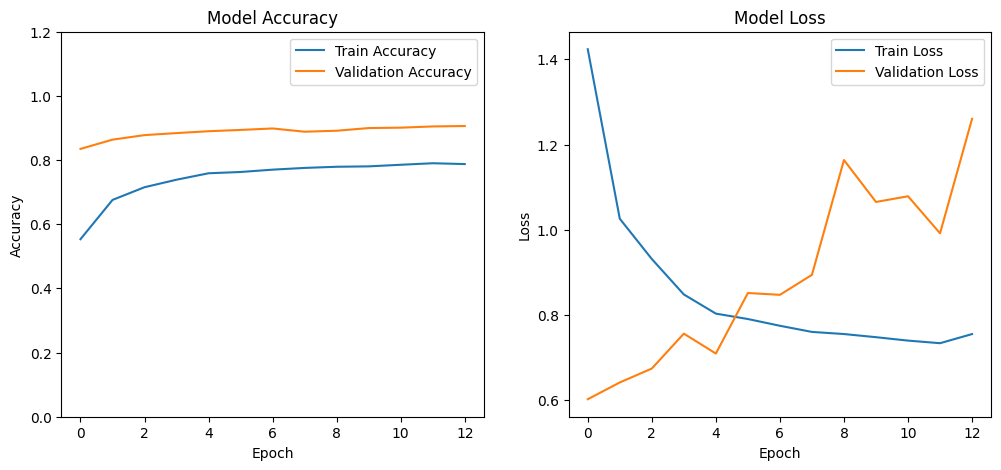



 Evaluate using validation data
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 32s 13ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.82      0.98      0.89       188
  biological       0.87      0.98      0.92       199
   cardboard       0.93      0.84      0.88       365
     clothes       0.99      0.97      0.98      1067
       glass       0.87      0.92      0.90       614
       metal       0.82      0.78      0.80       204
       paper       0.79      0.88      0.83       336
     plastic       0.90      0.78      0.83       396
       shoes       0.97      0.97      0.97       401
       trash       0.83      0.75      0.79       189

    accuracy                           0.90      3959
   macro avg       0.88      0.88      0.88      3959
weighted avg       0.91      0.90      0.90      3959



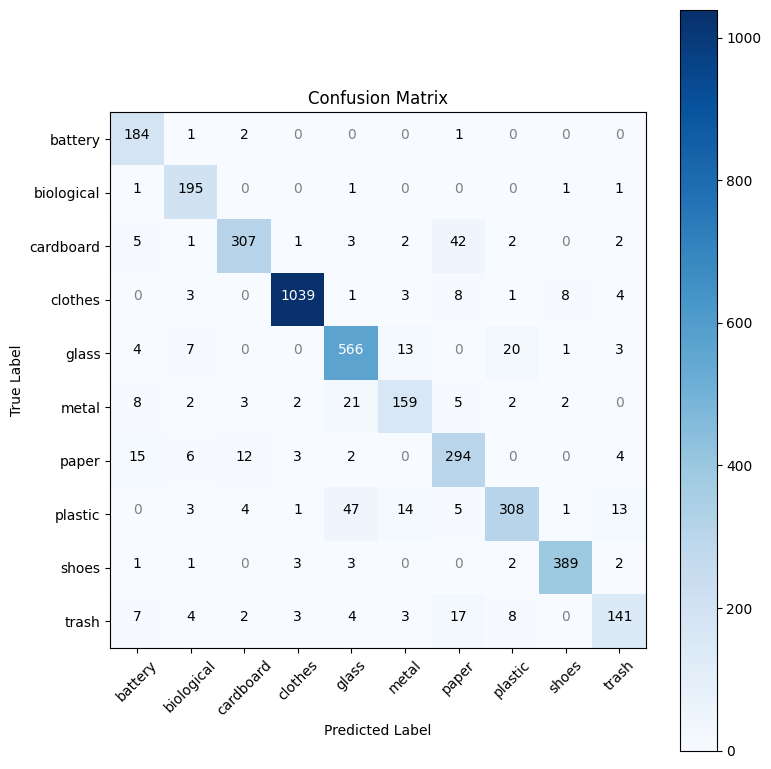



 Evaluate using test data
 10/996 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.84      0.96      0.89        96
  biological       0.87      0.94      0.90       101
   cardboard       0.91      0.84      0.87       183
     clothes       0.98      0.98      0.98       535
       glass       0.85      0.91      0.88       308
       metal       0.78      0.65      0.71       102
       paper       0.78      0.87      0.82       168
     plastic       0.90      0.79      0.84       200
       shoes       0.94      0.97      0.95       202
       trash       0.85      0.75      0.80        96

    accuracy                           0.90      1991
   macro avg       0.87      0.86      0.86      1991
weighted avg       0.90      0.90      0.89      1991



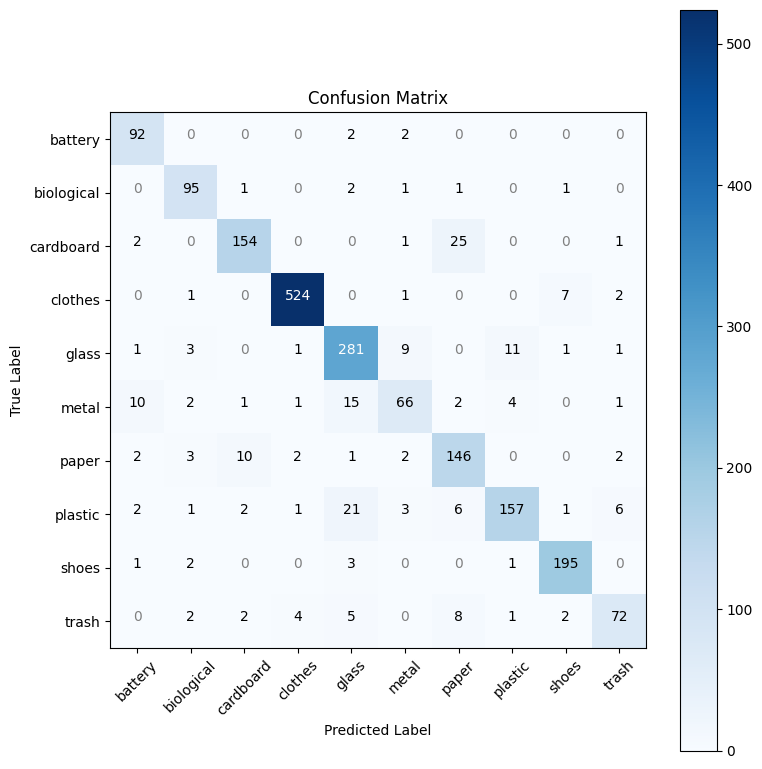

Model saved to Result/Model/Model_InceptionV3/model.h5


In [ ]:
# Direktori untuk model
output_dir_model_InceptionV3 = os.path.join(output_root, "Model_InceptionV3")
os.makedirs(output_dir_model_InceptionV3, exist_ok=True)

# Melatih model
train_cnn_model(
    model_InceptionV3,
    os.path.join("Dataset_R", "train"),
    os.path.join("Dataset_R", "val"),
    os.path.join("Dataset_R", "test"),
    epochs=20,
    batch_size=2,
    output_dir=output_dir_model_InceptionV3
)

In [ ]:
shutil.copytree(f"/content/Result/Model/{output_dir_model_InceptionV3}", f"/content/drive/MyDrive/Dataset/Result/Model/{output_dir_model_InceptionV3}", dirs_exist_ok=True)

##2. MobileNetV2

In [ ]:
from tensorflow.keras.applications import MobileNetV2

# Load MobileNetV2 pre-trained model
base_model = MobileNetV2(
    weights='imagenet',  # Pre-trained weights on ImageNet
    include_top=False,   # Tidak menyertakan fully connected layer bawaan
    input_shape=(224, 224, 3)
)

# Tambahkan lapisan kustom setelah MobileNetV2
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Global Average Pooling
x = BatchNormalization()(x)      # Batch Normalization
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout untuk mencegah overfitting
x = Dense(64, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)              # Dropout
outputs = Dense(count_various_classes, activation='softmax')(x)  # Output layer

# Gabungkan base model dengan lapisan kustom
model_MobileNetV2 = Model(inputs=base_model.input, outputs=outputs)

# Freeze semua lapisan pada base model untuk transfer learning awal
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model_MobileNetV2.compile(
    optimizer=Adam(learning_rate=0.001),  # Optimizer Adam dengan learning rate kecil
    loss='categorical_crossentropy',     # Loss untuk klasifikasi multi-kelas
    metrics=['accuracy']
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Found 13862 images belonging to 10 classes.
Found 3959 images belonging to 10 classes.
Found 1991 images belonging to 10 classes.
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6931/6931 ━━━━━━━━━━━━━━━━━━━━ 90s 12ms/step - accuracy: 0.4748 - loss: 1.6664 - val_accuracy: 0.8429 - val_loss: 0.6504
Epoch 2/50
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 138s 12ms/step - accuracy: 0.6875 - loss: 1.0100 - val_accuracy: 0.8530 - val_loss: 0.6542
Epoch 3/50
6931/6931 ━━━━━━━━━━━━━━━━━━━━ 79s 11ms/step - accuracy: 0.7147 - loss: 0.9270 - val_accuracy: 0.8757 - val_loss: 0.6987
Epoch 3: early stopping
Restoring model weights from the end of the best epoch: 1.


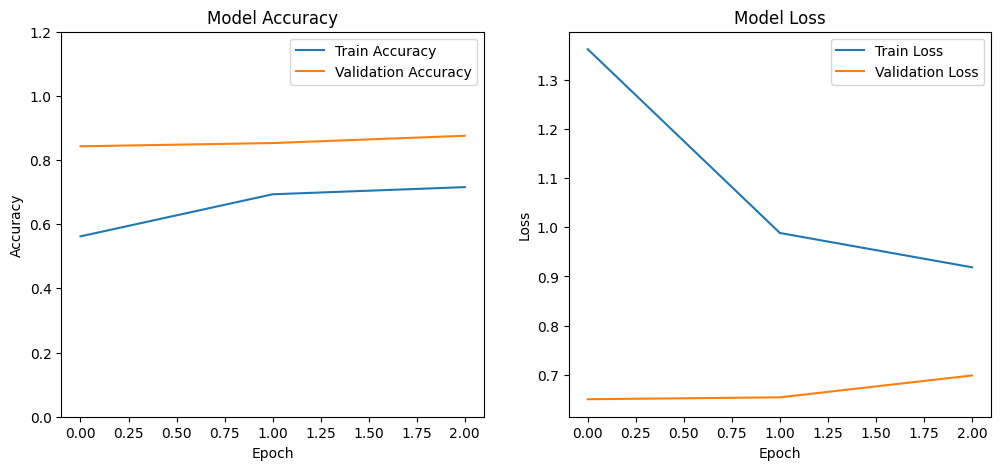



 Evaluate using validation data
1980/1980 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.81      0.86      0.84       188
  biological       0.81      0.97      0.89       199
   cardboard       0.75      0.80      0.77       365
     clothes       0.96      0.97      0.96      1067
       glass       0.80      0.88      0.84       614
       metal       0.81      0.58      0.68       204
       paper       0.69      0.82      0.75       336
     plastic       0.80      0.64      0.71       396
       shoes       0.94      0.97      0.95       401
       trash       0.77      0.37      0.50       189

    accuracy                           0.84      3959
   macro avg       0.81      0.79      0.79      3959
weighted avg       0.84      0.84      0.84      3959



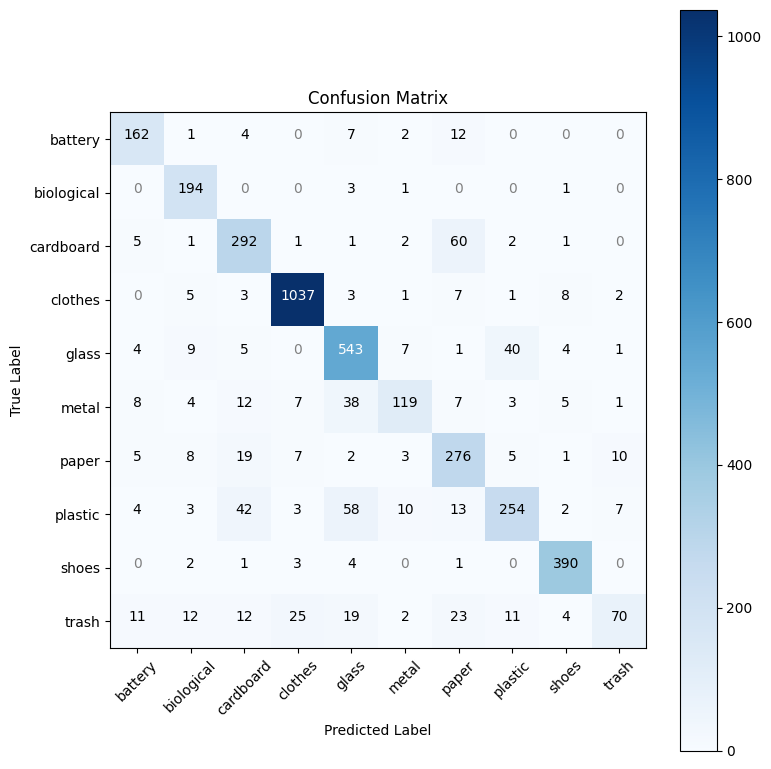



 Evaluate using test data
 27/996 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


996/996 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
Classification Report:
              precision    recall  f1-score   support

     battery       0.82      0.86      0.84        96
  biological       0.77      0.97      0.86       101
   cardboard       0.72      0.77      0.74       183
     clothes       0.95      0.96      0.96       535
       glass       0.77      0.86      0.81       308
       metal       0.74      0.55      0.63       102
       paper       0.68      0.79      0.73       168
     plastic       0.79      0.65      0.71       200
       shoes       0.94      0.95      0.94       202
       trash       0.71      0.33      0.45        96

    accuracy                           0.82      1991
   macro avg       0.79      0.77      0.77      1991
weighted avg       0.82      0.82      0.82      1991



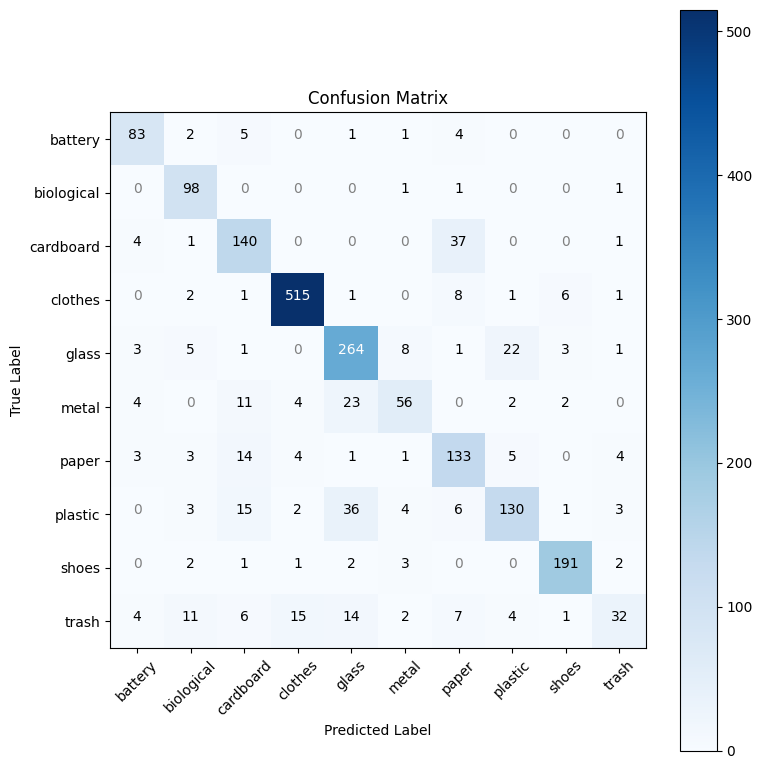

Model saved to Result/Model/Model_MobileNetV2/model.h5


In [ ]:
# Direktori untuk model
output_dir_model_MobileNetV2 = os.path.join(output_root, "Model_MobileNetV2")
os.makedirs(output_dir_model_MobileNetV2, exist_ok=True)

# Melatih model
train_cnn_model(
    model_MobileNetV2,
    os.path.join("Dataset_R", "train"),
    os.path.join("Dataset_R", "val"),
    os.path.join("Dataset_R", "test"),
    epochs=50,
    batch_size=2,
    output_dir=output_dir_model_MobileNetV2
)

In [ ]:
shutil.copytree(f"/content/Result/Model/{output_dir_model_MobileNetV2}", f"/content/drive/MyDrive/Dataset/Result/Model/{output_dir_model_MobileNetV2}", dirs_exist_ok=True)

In [ ]:
def plot_accuracy(df, output_dir):
    """
    Generate a bar plot of model accuracies with accuracy values displayed above the bars.
    """
    model_names = df.columns[1:]  # Skip the first column which is "Model_acc"
    validation_acc = df.iloc[0, 1:].values
    test_acc = df.iloc[1, 1:].values

    fig, ax = plt.subplots(figsize=(10, 6))
    bar_width = 0.35
    index = range(len(model_names))

    bar1 = ax.bar(index, validation_acc, bar_width, label='Validation Accuracy', color='forestgreen')
    bar2 = ax.bar([i + bar_width for i in index], test_acc, bar_width, label='Test Accuracy', color='yellowgreen')

    for i, rect in enumerate(bar1):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01,
                f'{rect.get_height():.2f}', ha='center', va='bottom', fontsize=10, color='black')

    for i, rect in enumerate(bar2):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01,
                f'{rect.get_height():.2f}', ha='center', va='bottom', fontsize=10, color='black')

    ax.set_xlabel('Model')
    ax.set_ylabel('Accuracy')
    ax.set_title('Accuracy Comparison for Each Model')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels(model_names)
    ax.set_ylim(0, 1)
    ax.legend()

    plt.tight_layout()
    plt.savefig(f'{output_dir}/bar_plot_compare_acc.png')
    plt.show()

In [ ]:
!zip -r 'Result.zip' '/content/Result'

  adding: content/Result/ (stored 0%)
  adding: content/Result/Model/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/Confusion_Matrix.png (deflated 13%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Test/classification_report.txt (deflated 66%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/ (stored 0%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/Confusion_Matrix.png (deflated 12%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Validation/classification_report.txt (deflated 66%)
  adding: content/Result/Model/Model_MobileNetV2/Evaluation/Plot_visualization.png (deflated 13%)
  adding: content/Result/Model/Model_MobileNetV2/model.h5 (deflated 11%)
  adding: content/Result